In [1]:
import GamificationRL
from collections import defaultdict
import gymnasium as gym
from GamificationRL.envs.gamification_elements import *
import random
from itertools import permutations
from adaptive_agent import *
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from hexad_answer_bot import *

plt.rcParams["figure.figsize"] = (10, 7)
import pandas as pd

hexad_types_full = [
    "Player",
    "Achiever",
    "Philanthropist",
    "Disruptor",
    "Socializer",
    "Free Spirit",
]
import logging

gym.logger.setLevel(logging.CRITICAL)

#### Environment Init

In [2]:
corr_g_e = list(corr_gamification_elements.values())
sample_g_e = list(sample_gamification_elements.values())
g_e = sample_g_e[1::2]
colors = [
    "violet",
    "purple",
    "red",
    "sienna",
    "darkorange",
    "burlywood",
    "gold",
    "darkgoldenrod",
    "olivedrab",
    "lawngreen",
    "deepskyblue",
    "steelblue",
]
ge2c = {"Nothing": "black"}
for i in range(len(g_e)):
    ge2c[g_e[i].name] = colors[i]
#hexad = hexad_load_dict(pl=2, ach=5, ph=4, dis=0.5, s=1, fs=3).load_dict
hexad=hexad_load_dict(pl=3,ach=3,ph=3,dis=3,s=3,fs=3).load_dict
fatigue_penalty = 0.05
fatigue_replenishment = 0.01
nothing_reward = 75
rrange = (1.0, 1.3, 1.7)
increase = (0.2, 0.1, 0.05)
decrease = (0.1, 0.1, 0.1)
pref_min = 0.2
seed = 10101

In [3]:
env = gym.make(
    "GamificationRL/GamificationPreferenceEnv-v0",
    hexad_load=hexad,
    gamification_elements=g_e,
    use_fatigue=True,
    individual_modifications=None,
    repetition_penalty=(400, 800),
    nothing_reward=nothing_reward,
    fatigue_reduction=fatigue_penalty,
    fatigue_replenish=fatigue_replenishment,
    pref_ranges=rrange,
    pref_increase=increase,
    pref_decrease=decrease,
    pref_min=pref_min,
    seed=seed,
)
obs, _ = env.reset()

#### Answer Bot Init

In [4]:
uncertainty = 0.1
divisor = 5.5
starting_threshold = 0.1
gain_modifier = 0.02
amount = 1
#ht = copy.deepcopy(hexad)
ht=hexad_load_dict(pl=2,ach=5,ph=4,dis=0.5,s=1,fs=3).load_dict

In [5]:
bot = ScoreChangeBot(
    hexad_types=copy.deepcopy(ht),
    uncertainty=uncertainty,
    divisor=divisor,
    starting_change_threshold=starting_threshold,
    change_gain_modifier=gain_modifier,
    change_amount=amount,
    seed=seed,
)

#### Agent init

In [6]:
# general parameters
learn_rate = 0.002
discount_factor = 0.7

In [7]:
# Fatigue-aware parameters
epsilon = 1
epsilon_min = 0.1
# training_iterations=int(1e6)
training_iterations = int(1e5)
epsilon_decay = (epsilon - epsilon_min) / (training_iterations * 3 / 4000)

In [8]:
fa_agent = FatigueAwareAgent(
    learn_rate=learn_rate,
    discount_factor=discount_factor,
    env=env,
    epsilon=epsilon,
    epsilon_decay=epsilon_decay,
    epsilon_min=epsilon_min,
)
train_error = fa_agent.train(env=env, iterations=training_iterations, trunc_error=True)

In [9]:
# Epsilon agent parameters
epsilon = 1
epsilon_min = 0.1
# training_iterations=int(1e6)
training_iterations = int(1e5)
epsilon_decay = (epsilon - epsilon_min) / (training_iterations * 3 / 4000)

In [10]:
e_agent = EpsilonAGAgent(
    learn_rate=learn_rate,
    discount_factor=discount_factor,
    env=env,
    epsilon=epsilon,
    epsilon_decay=epsilon_decay,
    epsilon_min=epsilon_min,
)
train_error = e_agent.train(env=env, iterations=training_iterations, trunc_error=True)

In [11]:
basic_agent = BasicAGAgent(
    learn_rate=learn_rate,
    discount_factor=discount_factor,
    env=env,
)
train_error = basic_agent.train(
    env=env, iterations=training_iterations, trunc_error=True
)

In [12]:
# RandomBestOfX parameters
epsilon = 1
epsilon_min = 0.1
# training_iterations=int(1e6)
training_iterations = int(1e5)
epsilon_decay = (epsilon - epsilon_min) / (training_iterations * 4 / 5000)
x = 3

In [13]:
boX_agent = RandomBestOfX(
    learn_rate=learn_rate,
    discount_factor=discount_factor,
    env=env,
    epsilon=epsilon,
    epsilon_decay=epsilon_decay,
    epsilon_min=epsilon_min,
    X=x,
)

train_error = boX_agent.train(env=env, iterations=training_iterations, trunc_error=True)

In [14]:
agents = {
    "Basic": basic_agent,
    "Epsilon": e_agent,
    "BestOfX": boX_agent,
    "FatigueAware": fa_agent,
}
init_q_values = {}
for name, agent in agents.items():
    init_q_values[name] = copy.deepcopy(agent.q_values)

#### Testing Functions

In [15]:
def test_env_agent(
    env,
    agent,
    answer_bot,
    test_iterations,
    retrain_iterations,
    random_retrain,
    training_lr,
):
    rewards = []
    choices = []
    best = []
    agent_error = []
    actions = defaultdict(lambda: {"x": [], "y": []})
    hexad_diff = []
    hd_stats = {"mean": [], "std": []}
    obs, info = env.reset()
    for i in tqdm(range(test_iterations),miniters=int(test_iterations/100)):
        best.append(env.get_best_action())
        act = agent.get_action(obs, avoid_reps=True)
        h_type = env.ge[env.action_to_ge[act]].type
        answer, _ = answer_bot.get_answer(h_type)
        choice, reward, new_obs, info, error = agent.step_and_update(
            env=env,
            obs=obs,
            answer=answer,
            retrain_iterations=retrain_iterations,
            learning_rate=training_lr,
            random_retrain=random_retrain,
            act=act,
        )
        choices.append(choice)
        rewards.append(reward)
        agent_error.append(error)
        actions[choice]["x"].append(i)
        actions[choice]["y"].append(reward)
        diff = 0
        d_s = []
        for typ, val in answer_bot.hexad_profile.items():
            v = abs(val - env.hexad_adjusted[typ])
            diff += v
            d_s.append(v)
        hd_stats["mean"].append(np.mean(d_s))
        hd_stats["std"].append(np.std(d_s))
        hexad_diff.append(diff)
        obs = new_obs
    return (
        rewards,
        choices,
        best,
        agent_error,
        actions,
        (obs, info),
        hexad_diff,
        hd_stats,
    )

In [16]:
def plot_actions(actions, env, title=None, f=1):
    typ = "pl"
    fig = plt.figure(f, figsize=(12, 7))
    fig.suptitle(title)
    for i, _ in sorted(actions.items()):
        name = env.action_to_ge[i]
        hex_type = env.ge[name].type
        if hex_type != None:
            plt.figure(f)
            type_index = hexad_types.index(env.ge[name].type) + 1
        else:
            plt.figure(f + 1)
        plt.subplot(3, 2, type_index)
        plt.ylim(0, 1000)
        plt.xlim(0, 1000)
        plt.scatter(actions[i]["x"], actions[i]["y"], label=name, s=2)
        ax = plt.gca()
        ax.legend()
    plt.figure(f + 2)
    fig.suptitle(title)
    for i in actions:
        plt.scatter(actions[i]["x"], actions[i]["y"], label=env.action_to_ge[i], s=5)
        ax = plt.gca()
        ax.legend()

In [17]:
def get_stats(actions, best, choices):
    type_stats = defaultdict(lambda: 0)
    for i in actions:
        try:
            type_stats[sample_gamification_elements[env.action_to_ge[i]].type] += len(
                actions[i]["x"]
            )
        except KeyError:
            type_stats["None"] += len(actions[i]["x"])
    s = 0
    for i in range(len(best)):
        if best[i][1] == choices[i][1]:
            s += 1
    diff = [best[i][1] - choices[i][1] for i in range(len(choices))]
    diff = np.array(diff)
    diff = diff[diff > 0.01]
    actual = pd.Series([env.action_to_ge[item[0]] for item in best], name="Actual Best")
    pred = pd.Series([env.action_to_ge[item[0]] for item in b], name="Predicted Best")
    conf_matrix = pd.crosstab(actual, pred, margins=True)
    return type_stats, s / len(best), diff, conf_matrix

#### Hyperparameter tuning

##### Hexad Preference range

In [18]:
test_range=[.0,.1,.2,.3,.4,.5,.6,.7,.8,.9]


In [20]:
tests = 500
retrains = 1000
retrain_learn_rate = 0.3
accs = {}
a_e = {}
d_b = {}
hexad_diff = {}
j = 0
for name, agent in agents.items():
    print(name)
    random_retrain = name == "Basic" or name == "BestOfX"
    accs[name] = {"avg": [], "std": []}
    a_e[name] = {"avg": [], "std": []}
    d_b[name] = {"avg": [], "std": []}
    hexad_diff[name] = {"avg": [], "std": []}
    for uncertainty in tqdm(test_range):
        print(f"Current test: {uncertainty}")
        print("Iteration: ", end="")
        accuracy = []
        diff_from_best = []
        agent_error = []
        abs_hex_diff = []
        for j in range(3):
            bot = ScoreChangeBot(
                hexad_types=copy.deepcopy(ht),
                uncertainty=uncertainty,
                divisor=divisor,
                starting_change_threshold=starting_threshold,
                change_gain_modifier=gain_modifier,
                change_amount=amount,
                seed=seed,
            )
            env = gym.make(
                "GamificationRL/GamificationPreferenceEnv-v0",
                hexad_load=hexad,
                gamification_elements=g_e,
                use_fatigue=True,
                individual_modifications=None,
                repetition_penalty=(400, 800),
                nothing_reward=nothing_reward,
                fatigue_reduction=fatigue_penalty,
                fatigue_replenish=fatigue_replenishment,
                pref_ranges=rrange,
                pref_increase=increase,
                pref_decrease=decrease,
                pref_min=pref_min,
                seed=seed,
            )
            obs, _ = env.reset()
            agent.reset()
            agent.train(env=env, iterations=training_iterations, trunc_error=True)
            obs, _ = env.reset()
            print(f"{j+1}, ", end="")
            r, c, b, e, a, _, hd, hd_stats = test_env_agent(
                env,
                agent,
                answer_bot=bot,
                test_iterations=tests,
                retrain_iterations=retrains,
                random_retrain=random_retrain,
                training_lr=retrain_learn_rate,
            )
            t, acc, diff, conf_matrix = get_stats(a, b, [*zip(c, r)])
            accuracy.append(acc)
            diff_from_best.extend((diff))
            agent_error.extend((e))
            abs_hex_diff.extend(hd)
        print()
        hexad_diff[name]["avg"].append(np.average(abs_hex_diff))
        hexad_diff[name]["std"].append(np.std(abs_hex_diff))
        accs[name]["avg"].append(np.average(accuracy))
        accs[name]["std"].append(np.std(accuracy))
        a_e[name]["avg"].append(np.average(agent_error))
        a_e[name]["std"].append(np.std(agent_error))
        d_b[name]["avg"].append(np.average(diff_from_best))
        d_b[name]["std"].append(np.std(diff_from_best))

Basic


  0%|          | 0/10 [00:00<?, ?it/s]

Current test: 0.0
Iteration: 1, 

100%|██████████| 500/500 [00:11<00:00, 45.43it/s]


2, 

100%|██████████| 500/500 [00:11<00:00, 43.85it/s]


3, 

 10%|█         | 1/10 [00:40<06:05, 40.59s/it]


Current test: 0.1
Iteration: 1, 

100%|██████████| 500/500 [00:11<00:00, 44.68it/s]


2, 

100%|██████████| 500/500 [00:11<00:00, 44.02it/s]


3, 

 20%|██        | 2/10 [01:21<05:25, 40.74s/it]


Current test: 0.2
Iteration: 1, 

100%|██████████| 500/500 [00:11<00:00, 42.72it/s]


2, 

100%|██████████| 500/500 [00:11<00:00, 42.56it/s]


3, 

 30%|███       | 3/10 [02:03<04:49, 41.37s/it]


Current test: 0.3
Iteration: 1, 

100%|██████████| 500/500 [00:11<00:00, 43.77it/s]


2, 

100%|██████████| 500/500 [00:11<00:00, 43.54it/s]


3, 

 40%|████      | 4/10 [02:45<04:09, 41.56s/it]


Current test: 0.4
Iteration: 1, 

100%|██████████| 500/500 [00:11<00:00, 41.83it/s]


2, 

100%|██████████| 500/500 [00:10<00:00, 45.47it/s]


3, 

 50%|█████     | 5/10 [03:26<03:27, 41.56s/it]


Current test: 0.5
Iteration: 1, 

100%|██████████| 500/500 [00:11<00:00, 43.43it/s]


2, 

100%|██████████| 500/500 [00:11<00:00, 45.21it/s]


3, 

 60%|██████    | 6/10 [04:08<02:45, 41.48s/it]


Current test: 0.6
Iteration: 1, 

100%|██████████| 500/500 [00:11<00:00, 42.54it/s]


2, 

100%|██████████| 500/500 [00:11<00:00, 41.85it/s]


3, 

 70%|███████   | 7/10 [04:50<02:05, 41.72s/it]


Current test: 0.7
Iteration: 1, 

100%|██████████| 500/500 [00:11<00:00, 43.02it/s]


2, 

100%|██████████| 500/500 [00:12<00:00, 41.58it/s]


3, 

 80%|████████  | 8/10 [05:33<01:24, 42.13s/it]


Current test: 0.8
Iteration: 1, 

100%|██████████| 500/500 [00:11<00:00, 45.43it/s]


2, 

100%|██████████| 500/500 [00:11<00:00, 45.07it/s]


3, 

 90%|█████████ | 9/10 [06:13<00:41, 41.39s/it]


Current test: 0.9
Iteration: 1, 

100%|██████████| 500/500 [00:10<00:00, 46.84it/s]


2, 

100%|██████████| 500/500 [00:10<00:00, 46.74it/s]


3, 

100%|██████████| 10/10 [06:52<00:00, 41.21s/it]



Epsilon


  0%|          | 0/10 [00:00<?, ?it/s]

Current test: 0.0
Iteration: 1, 

100%|██████████| 500/500 [00:12<00:00, 39.54it/s]


2, 

100%|██████████| 500/500 [00:12<00:00, 38.67it/s]


3, 

 10%|█         | 1/10 [00:45<06:48, 45.43s/it]


Current test: 0.1
Iteration: 1, 

100%|██████████| 500/500 [00:12<00:00, 39.08it/s]


2, 

100%|██████████| 500/500 [00:12<00:00, 38.83it/s]


3, 

 20%|██        | 2/10 [01:30<06:03, 45.44s/it]


Current test: 0.2
Iteration: 1, 

100%|██████████| 500/500 [00:12<00:00, 39.68it/s]


2, 

100%|██████████| 500/500 [00:11<00:00, 41.96it/s]


3, 

 30%|███       | 3/10 [02:13<05:09, 44.28s/it]


Current test: 0.3
Iteration: 1, 

100%|██████████| 500/500 [00:12<00:00, 38.50it/s]


2, 

100%|██████████| 500/500 [00:13<00:00, 37.69it/s]


3, 

 40%|████      | 4/10 [03:00<04:30, 45.06s/it]


Current test: 0.4
Iteration: 1, 

100%|██████████| 500/500 [00:12<00:00, 39.22it/s]


2, 

100%|██████████| 500/500 [00:12<00:00, 38.83it/s]


3, 

 50%|█████     | 5/10 [03:44<03:44, 45.00s/it]


Current test: 0.5
Iteration: 1, 

100%|██████████| 500/500 [00:12<00:00, 39.56it/s]


2, 

100%|██████████| 500/500 [00:13<00:00, 36.72it/s]


3, 

 60%|██████    | 6/10 [04:33<03:04, 46.05s/it]


Current test: 0.6
Iteration: 1, 

100%|██████████| 500/500 [00:14<00:00, 33.76it/s]


2, 

100%|██████████| 500/500 [00:13<00:00, 37.57it/s]


3, 

 70%|███████   | 7/10 [05:21<02:20, 46.82s/it]


Current test: 0.7
Iteration: 1, 

100%|██████████| 500/500 [00:13<00:00, 36.42it/s]


2, 

100%|██████████| 500/500 [00:13<00:00, 38.00it/s]


3, 

 80%|████████  | 8/10 [06:08<01:33, 46.78s/it]


Current test: 0.8
Iteration: 1, 

100%|██████████| 500/500 [00:13<00:00, 36.40it/s]


2, 

100%|██████████| 500/500 [00:13<00:00, 37.62it/s]


3, 

 90%|█████████ | 9/10 [06:54<00:46, 46.80s/it]


Current test: 0.9
Iteration: 1, 

100%|██████████| 500/500 [00:13<00:00, 37.08it/s]


2, 

100%|██████████| 500/500 [00:13<00:00, 36.57it/s]


3, 

100%|██████████| 10/10 [07:42<00:00, 46.24s/it]



BestOfX


  0%|          | 0/10 [00:00<?, ?it/s]

Current test: 0.0
Iteration: 1, 

100%|██████████| 500/500 [00:15<00:00, 33.23it/s]


2, 

100%|██████████| 500/500 [00:13<00:00, 37.31it/s]


3, 

 10%|█         | 1/10 [00:49<07:25, 49.51s/it]


Current test: 0.1
Iteration: 1, 

100%|██████████| 500/500 [00:11<00:00, 42.51it/s]


2, 

100%|██████████| 500/500 [00:11<00:00, 43.73it/s]


3, 

 20%|██        | 2/10 [01:31<05:59, 44.92s/it]


Current test: 0.2
Iteration: 1, 

100%|██████████| 500/500 [00:11<00:00, 42.59it/s]


2, 

100%|██████████| 500/500 [00:11<00:00, 43.71it/s]


3, 

 30%|███       | 3/10 [02:12<05:04, 43.46s/it]


Current test: 0.3
Iteration: 1, 

100%|██████████| 500/500 [00:12<00:00, 40.07it/s]


2, 

100%|██████████| 500/500 [00:11<00:00, 42.67it/s]


3, 

 40%|████      | 4/10 [02:55<04:19, 43.27s/it]


Current test: 0.4
Iteration: 1, 

100%|██████████| 500/500 [00:12<00:00, 41.09it/s]


2, 

100%|██████████| 500/500 [00:11<00:00, 42.46it/s]


3, 

 50%|█████     | 5/10 [03:38<03:34, 42.88s/it]


Current test: 0.5
Iteration: 1, 

100%|██████████| 500/500 [00:12<00:00, 41.24it/s]


2, 

100%|██████████| 500/500 [00:11<00:00, 43.00it/s]


3, 

 60%|██████    | 6/10 [04:20<02:50, 42.64s/it]


Current test: 0.6
Iteration: 1, 

100%|██████████| 500/500 [00:11<00:00, 44.05it/s]


2, 

100%|██████████| 500/500 [00:11<00:00, 43.10it/s]


3, 

 70%|███████   | 7/10 [05:01<02:06, 42.18s/it]


Current test: 0.7
Iteration: 1, 

100%|██████████| 500/500 [00:11<00:00, 44.01it/s]


2, 

100%|██████████| 500/500 [00:11<00:00, 43.34it/s]


3, 

 80%|████████  | 8/10 [05:43<01:24, 42.19s/it]


Current test: 0.8
Iteration: 1, 

100%|██████████| 500/500 [00:11<00:00, 43.19it/s]


2, 

100%|██████████| 500/500 [00:11<00:00, 44.54it/s]


3, 

 90%|█████████ | 9/10 [06:25<00:41, 41.95s/it]


Current test: 0.9
Iteration: 1, 

100%|██████████| 500/500 [00:11<00:00, 42.83it/s]


2, 

100%|██████████| 500/500 [00:11<00:00, 43.17it/s]


3, 

100%|██████████| 10/10 [07:07<00:00, 42.79s/it]



FatigueAware


  0%|          | 0/10 [00:00<?, ?it/s]

Current test: 0.0
Iteration: 1, 

100%|██████████| 500/500 [00:13<00:00, 38.44it/s]


2, 

100%|██████████| 500/500 [00:13<00:00, 37.96it/s]


3, 

 10%|█         | 1/10 [00:46<06:57, 46.39s/it]


Current test: 0.1
Iteration: 1, 

100%|██████████| 500/500 [00:13<00:00, 37.93it/s]


2, 

100%|██████████| 500/500 [00:14<00:00, 33.34it/s]


3, 

 20%|██        | 2/10 [01:36<06:29, 48.68s/it]


Current test: 0.2
Iteration: 1, 

100%|██████████| 500/500 [00:14<00:00, 35.41it/s]


2, 

100%|██████████| 500/500 [00:14<00:00, 33.67it/s]


3, 

 30%|███       | 3/10 [02:28<05:50, 50.06s/it]


Current test: 0.3
Iteration: 1, 

100%|██████████| 500/500 [00:14<00:00, 34.47it/s]


2, 

100%|██████████| 500/500 [00:16<00:00, 30.31it/s]


3, 

 40%|████      | 4/10 [03:20<05:05, 50.86s/it]


Current test: 0.4
Iteration: 1, 

100%|██████████| 500/500 [00:14<00:00, 34.20it/s]


2, 

100%|██████████| 500/500 [00:13<00:00, 35.81it/s]


3, 

 50%|█████     | 5/10 [04:09<04:11, 50.25s/it]


Current test: 0.5
Iteration: 1, 

100%|██████████| 500/500 [00:13<00:00, 36.03it/s]


2, 

100%|██████████| 500/500 [00:14<00:00, 34.40it/s]


3, 

 60%|██████    | 6/10 [04:58<03:18, 49.70s/it]


Current test: 0.6
Iteration: 1, 

100%|██████████| 500/500 [00:15<00:00, 32.47it/s]


2, 

100%|██████████| 500/500 [00:13<00:00, 36.50it/s]


3, 

 70%|███████   | 7/10 [05:47<02:28, 49.60s/it]


Current test: 0.7
Iteration: 1, 

100%|██████████| 500/500 [00:13<00:00, 37.70it/s]


2, 

100%|██████████| 500/500 [00:13<00:00, 37.15it/s]


3, 

 80%|████████  | 8/10 [06:33<01:37, 48.56s/it]


Current test: 0.8
Iteration: 1, 

100%|██████████| 500/500 [00:13<00:00, 37.03it/s]


2, 

100%|██████████| 500/500 [00:14<00:00, 34.36it/s]


3, 

 90%|█████████ | 9/10 [07:24<00:49, 49.24s/it]


Current test: 0.9
Iteration: 1, 

100%|██████████| 500/500 [00:15<00:00, 31.86it/s]


2, 

100%|██████████| 500/500 [00:13<00:00, 36.06it/s]


3, 

100%|██████████| 10/10 [08:15<00:00, 49.52s/it]

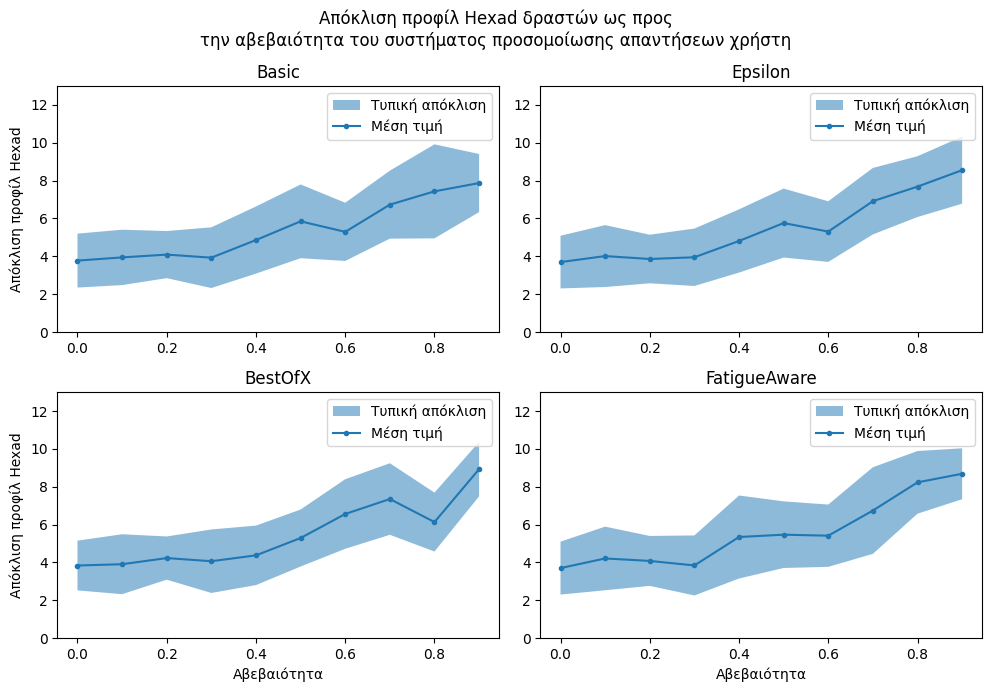

In [35]:
i = 1
for name, agent in agents.items():
    ax = plt.subplot(2, 2, i)
    av = np.array(hexad_diff[name]["avg"])
    st = np.array(hexad_diff[name]["std"])
    plt.errorbar(
        test_range, av, marker=".", capsize=2, label="Μέση τιμή"
    )
    plt.fill_between(test_range,av-st,av+st,alpha=0.5,label='Τυπική απόκλιση')
    plt.tight_layout(pad=1)
    plt.ylim(0,13)
    plt.title(name)
    plt.legend()
    if i in [1, 3]:
        plt.ylabel("Απόκλιση προφίλ Hexad")
    if i in [3, 4]:
        plt.xlabel("Αβεβαιότητα")
    i += 1
plt.suptitle("Απόκλιση προφίλ Hexad δραστών ως προς\nτην αβεβαιότητα του συστήματος προσομοίωσης απαντήσεων χρήστη")
plt.tight_layout(pad=1)

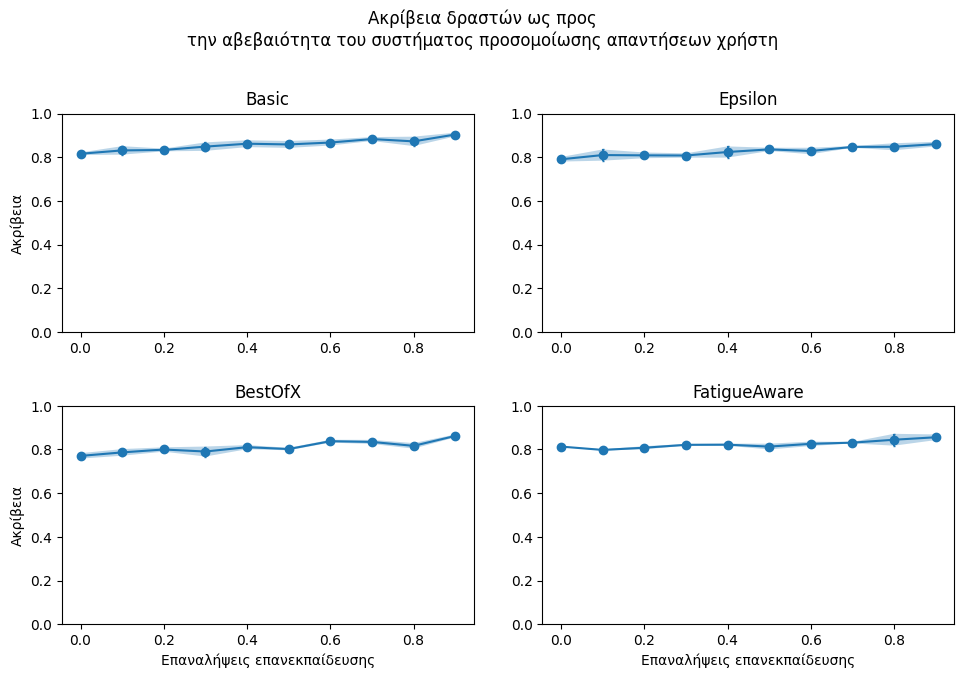

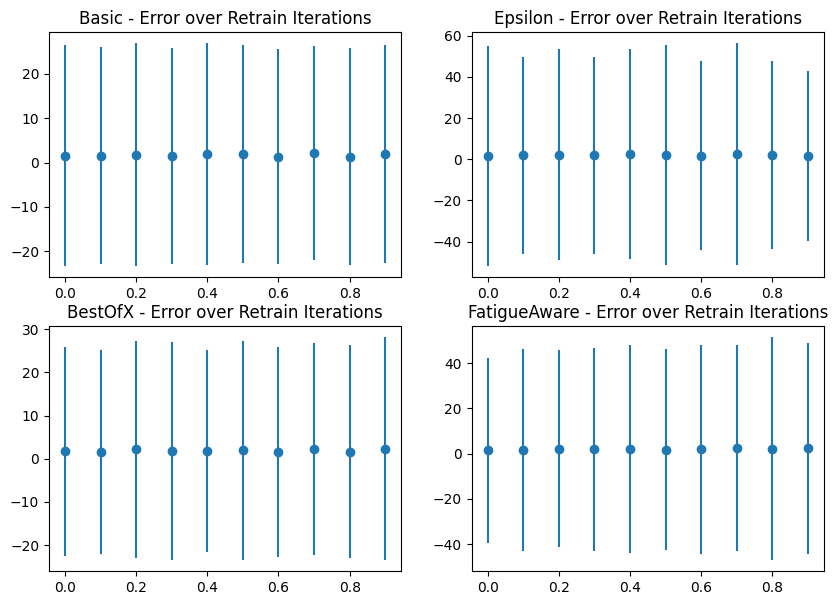

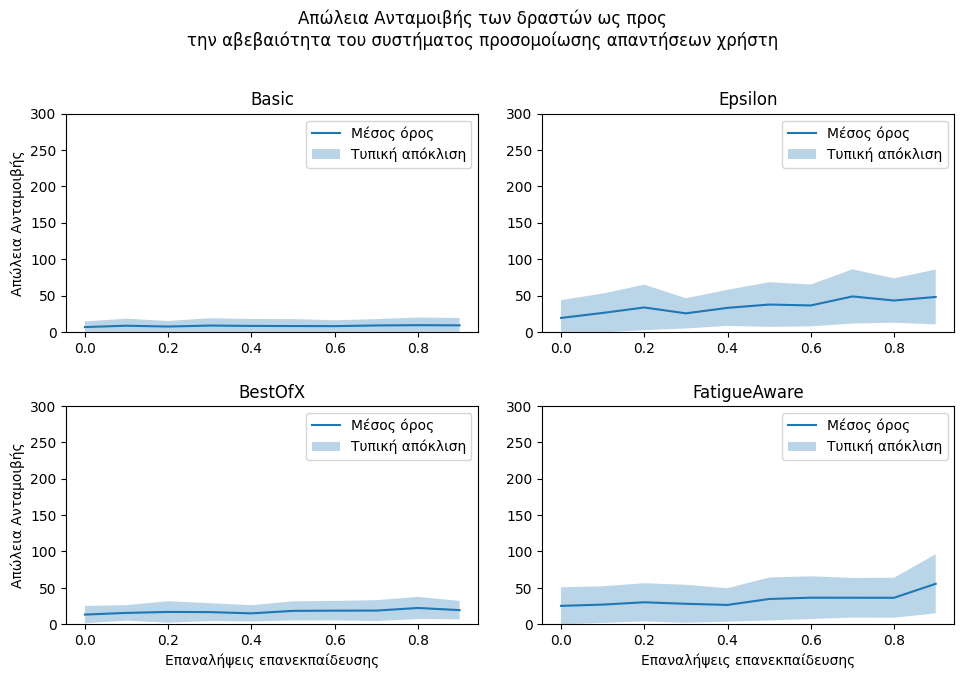

In [36]:
i = 1
for name, agent in agents.items():
    plt.figure(1)
    plt.subplot(2, 2, i)
    plt.errorbar(
        test_range, accs[name]["avg"], accs[name]["std"], marker="o", capsize=1
    )
    plt.fill_between(
        test_range,
        np.array(accs[name]["avg"]) - np.array(accs[name]["std"]),
        np.array(accs[name]["avg"]) + np.array(accs[name]["std"]),
        alpha=0.3,
    )
    plt.tight_layout(pad=2)
    plt.ylim(0, 1)
    if i in [1, 3]:
        plt.ylabel("Ακρίβεια")
    if i in [3, 4]:
        plt.xlabel("Επαναλήψεις επανεκπαίδευσης")
    plt.title("{}".format(name))
    plt.suptitle("Ακρίβεια δραστών ως προς\nτην αβεβαιότητα του συστήματος προσομοίωσης απαντήσεων χρήστη")
    plt.figure(2)
    plt.subplot(2, 2, i)
    plt.errorbar(
        test_range, a_e[name]["avg"], a_e[name]["std"], marker="o", linestyle=""
    )
    plt.title("{} - Error over Retrain Iterations".format(name))
    plt.figure(3)
    plt.subplot(2, 2, i)
    y = np.array(d_b[name]["avg"])
    y_error = np.array(d_b[name]["std"])
    plt.plot(test_range, y, label="Μέσος όρος")
    plt.fill_between(
        test_range, y - y_error / 2, y + y_error / 2, alpha=0.3, label="Τυπική απόκλιση"
    )
    plt.legend()
    plt.title("{}".format(name))
    plt.tight_layout(pad=2)
    plt.ylim(0, 300)
    if i in [1, 3]:
        plt.ylabel("Απώλεια Ανταμοιβής")
    if i in [3, 4]:
        plt.xlabel("Επαναλήψεις επανεκπαίδευσης")
    plt.suptitle(
        "Απώλεια Ανταμοιβής των δραστών ως προς\nτην αβεβαιότητα του συστήματος προσομοίωσης απαντήσεων χρήστη"
    )
    i += 1